# ASPEN Paper - Figure 5 and its supplement

In [182]:
# Loading required libraries
suppressPackageStartupMessages({
    library(openxlsx)
    library(scales)
    library(scater)
    library(dplyr)
    library(gamlss)
    library(ggplot2)
    library(ggpointdensity)
    library(ggsci)
    library(ggthemes)
    library(gridExtra)
    library(ggpubr)
    library(scales)
    library(foreach)
    library(reshape2)
    library(locfit)
    library(scran)
    library(zoo)
    library(MatchIt)
    library(coin)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(jcolors)
    library(ComplexHeatmap)
    library(ggvenn)
    library(tibble)
    library(ggridges)
})

Functions used for the analyses

In [192]:
#function to simulate counts expected for a given dispersion 
#(either expected for the genes with common dispersion or 
#based on the dispersion where the effect of GE differences is removed, i.e. residual dispersion)

#instead of calculating posterior counts, the counts are simulated using dispersion
make_plotdf_simul <- function(a1, a2, gene, estimates, init.seed = 10001101){

  df <- as.data.frame(cbind(a1 = as.numeric(a1[gene,]), a2 = as.numeric(a2[gene,])))
  df$tot <- df$a1 + df$a2
  df$AR <- df$a1/df$tot
 
  mu_orig <- estimates$bb_mu[rownames(estimates) == gene]
  theta_orig <- estimates$bb_theta[rownames(estimates) == gene]
  theta_common <- estimates$theta_common[rownames(estimates) == gene]
  theta_resid <- abs(theta_orig - theta_common)
  alpha_post0 <-  mu_orig/theta_resid
  beta_post0 <-  (1- mu_orig)/theta_resid  
  alpha_common <- mu_orig/theta_common
  beta_common <-  (1 - mu_orig)/theta_common 

  set.seed(init.seed)

  df$a1_post <- VGAM::rbetabinom.ab(length(df$tot), df$tot, shape1 = alpha_post0, shape2 = beta_post0) 
  df$a2_post <- df$tot - df$a1_post
  df$AR_post <- df$a1_post/(df$a1_post + df$a2_post)
  df$a1_common <- VGAM::rbetabinom.ab(length(df$tot), df$tot, shape1 = alpha_common, shape2 = beta_common)
  df$a2_common <- df$tot - df$a1_common
  df$AR_common <- df$a1_common/(df$a1_common + df$a2_common)  
  df$Index <- 1:nrow(df)
  df <- na.omit(df)
  return(df)
    
}

# Function to plot allelic ratio density between observed and expected groups
plot_density <- function(plot_data){

    df <- as.data.frame(rbind(cbind(AR = plot_data$AR, 
                                    type = "Observed"),
                              cbind(AR = plot_data$AR_common, 
                                type = "Expected")))
    df$AR <- as.numeric(df$AR)
    df$type <- factor(df$type, levels = c("Observed", "Expected"))
    ggplot(df, aes(x=AR, color=type)) +
        geom_density(linewidth = 1) +
        theme_classic(base_size = 20) +
        xlim(0,1) +
        scale_color_manual(values = c("black", "grey"), labels = c("Observed", "Expected")) +
        labs(x = "Allelic Ratio") +
        theme(legend.title = element_blank(), legend.position = "top") +
        theme(legend.box.spacing = unit(0, "pt")) 
}


# Function to plot dispersion estimates over mean gene expression
plot_scatter <- function(param_reestim){

  ggplot(param_reestim, aes(log(tot_gene_mean), log(bb_theta))) +
    geom_point(size = 0.7, colour = "darkgrey") +
    theme_classic(base_size = 20) +
    theme(legend.position = "none", legend.title = element_blank()) +
    annotate("text", x=2, y=3.5, label= paste("N genes:", nrow(param_reestim)), size = 6) 
   
}


#Preparing data for plotting
#this function extracts allelic counts and calculates allelic ratio for each cell
makedf <- function(a1, a2, gene){
  
  df <- as.data.frame(cbind(a1 = as.vector(a1[gene,]), a2 = as.vector(a2[gene,])))
  df$a1 <- as.numeric(df$a1)
  df$a2 <- as.numeric(df$a2)
  df$tot <- df$a1 + df$a2
  df$AR <- df$a1/df$tot
  #df <- df[order(df$tot),]
  df <- na.omit(df)
  df$Index <- 1:nrow(df)
  df
}

#scatter plot to evaluate allelic ratio distribution
#points are coloured by total counts
plot_distr_totGE <- function(plot_data, gene){
    
  p <- plot_data %>% ggplot(aes(AR, Index, colour = log(tot))) +
    theme_classic(base_size = 15) +
    geom_pointdensity(size = 0.9) +
    geom_vline(xintercept=0.5, linetype='longdash', color='lightgrey') +
    theme(plot.subtitle = element_text(hjust = 1)) +
    scale_colour_viridis_c(option = "mako", direction = -1) +
    theme(legend.position = "bottom", legend.box.spacing = unit(0, "pt"),
          axis.title.y = element_blank(), axis.text.y = element_blank()) +
    labs(x = "Allelic ratio") +
    xlim(0,1)
  p2 <-ggExtra::ggMarginal(p, type = "density", margin = "x", groupColour = F, groupFill = F, size = 3)
    
    p2

}

plot_scatter_density <- function(df){
      ggplot(df, aes(x = AR, y = group)) +
      geom_density_ridges(jittered_points = TRUE, position = "points_sina", alpha = 0.7) +
      theme_classic(base_size = 15) +
      theme(panel.grid.minor = element_blank(), axis.title.x = element_text(size = 15), axis.title.y = element_text(size = 15), axis.text.y = element_text(size = 15), axis.text.x = element_text(size = 15)) +
      theme(plot.title = element_text(size = 18), plot.subtitle = element_text(size = 14), 
             legend.title = element_blank(), legend.position = "bottom", legend.box.spacing = unit(0, "pt")) +
      labs(x = "Allelic Ratio") 
}

# Figure 5B

Evaluating monoallelic expression patterns across three cell types from the brain organoid datasets: radial glial cells (RGCs), intermediate progenitors (IPCs) and cortical neurons. Data for the female Bl6xCast hybrids was used for the analyses. 

In [36]:
#Loading test results
celltypes <- list("Cortical neurons", "IPCs", "RGCs")
res = "./aspen_output/brain_organoids/Bl6Cast/"
bb_mean_res_organoids <- lapply(celltypes, function(q) read.xlsx(paste0(res, "Bl6_Cast_organoids_ASPENmean.xlsx"), 
                                                                 sheet = paste0(q, "_Cast_B6"), rowNames = T))
bb_var_res_organoids <- lapply(celltypes, function(q) read.xlsx(paste0(res, "Bl6_Cast_organoids_ASPENvar.xlsx"), 
                                                                sheet = paste0(q, "_Cast_B6"), rowNames = T))


In [37]:
#combining test results into one table
organoids_res <- bb_mean_res_organoids
organoids_res <- mapply(function(p, q) {p$pval_var <- q$pval_disp[match(rownames(p), rownames(q))];
                                      return(p)}, organoids_res, bb_var_res_organoids, SIMPLIFY = FALSE)
lapply(organoids_res, dim) 

[[1]]
[1] 973  32

[[2]]
[1] 857  32

[[3]]
[1] 1078   32

In [38]:
organoids_res <- mapply(function(p, q) {p$celltype <- q;
                                        return(p)}, organoids_res, celltypes, SIMPLIFY = F)

In [39]:
#recalculating FDR
organoids_res <- lapply(organoids_res, function(q) {q$fdr_mean <- p.adjust(q$pval_mean, method = "fdr");
                                                    q$fdr_var <-  p.adjust(q$pval_var, method = "fdr");
                                                    q$vardeviat <- ifelse(q$fdr_var < 0.05, 1, 0);
                                                    q$abdiff <- abs(q$alpha - q$beta);
                                                    q$rme <- ifelse(q$alpha < 1 & q$beta < 1 & q$abdiff < 0.5, 1, 0);
                                                    q$mono <-  ifelse(q$alpha < 1 | q$beta < 1, 1, 0);
                                                    q$gene <- rownames(q);
                                                              return(q)})

In [12]:
#selecting genes that were identified as monoallelically expressed
organoids_res_select <- lapply(organoids_res, function(q) q[q$mono == 1,])
mono_genes <- unique(c(rownames(organoids_res_select[[1]]), 
                  rownames(organoids_res_select[[2]]), 
                  rownames(organoids_res_select[[3]])))
length(mono_genes)
mono_genes

[1] 72

[1] "Hspe1"         "Lypd1"         "Snhg11"        "Pcsk1n"       
 [5] "Tspan7"        "Ndufb11"       "Uba1"          "Pgrmc1"       
 [9] "Aff2"          "Ids"           "Nsdhl"         "Maged1"       
[13] "Rps4x"         "Tsix"          "Xist"          "Atrx"         
[17] "Sh3bgrl"       "Bex2"          "Pak3"          "Dcx"          
[21] "Zrsr2"         "Gpm6b"         "Sri"           "Gabra2"       
[25] "Hmgb1"         "Mrps33"        "Gm9794"        "Apoe"         
[29] "9330162G02Rik" "Snrpn"         "Rps15a"        "Mrpl23"       
[33] "Kcnq1ot1"      "Nefm"          "Eif4a1"        "Tubb2a"       
[37] "Gadd45g"       "Meg3"          "Angpt1"        "Tiam2"        
[41] "Rian"          "Ecrg4"         "Nono"          "Tceal8"       
[45] "Prdx4"         "H2ac20"        "Mt3"           "Mt1"          
[49] "Hmgn3"         "Pttg1"         "H2bc4"         "H4c3"         
[53] "Tuba1b"        "Hnrnpa1"       "Thrsp"         "Tmem47"       
[57] "Pdzd11"        "Magt1"         "Mageh1"        "Rab9"         
[61] "Stmn1"         "Uchl1"         "Hnrnpf"        "Peg3"         
[65] "Rpl23a"        "Nid1"          "H2ac6"         "H3c3"         
[69] "Acot1"         "Emp2"          "Plaat3"        "Ubb"

In [13]:
#selecting genes that were identified to have random monoallelic expression
organoids_res_select <- lapply(organoids_res, function(q) q[q$rme == 1,])
rme_genes <- unique(c(rownames(organoids_res_select[[1]]), 
                  rownames(organoids_res_select[[2]]), 
                  rownames(organoids_res_select[[3]])))
length(rme_genes)
rme_genes

[1] 39

[1] "Lypd1"   "Snhg11"  "Pcsk1n"  "Tspan7"  "Ndufb11" "Uba1"    "Pgrmc1" 
 [8] "Aff2"    "Ids"     "Nsdhl"   "Maged1"  "Rps4x"   "Tsix"    "Xist"   
[15] "Atrx"    "Sh3bgrl" "Bex2"    "Pak3"    "Dcx"     "Zrsr2"   "Gpm6b"  
[22] "Nefm"    "Tubb2a"  "Gadd45g" "Nono"    "Tceal8"  "Prdx4"   "Mt3"    
[29] "Hmgn3"   "Pttg1"   "H2bc4"   "Thrsp"   "Tmem47"  "Pdzd11"  "Magt1"  
[36] "Mageh1"  "Rab9"    "Acot1"   "Emp2"

In [23]:
#selecting monoallelic genes that are expressed in all three cell types for plotting
select_genes <- c("Uchl1", "Eif4a1", "Meg3", "Hmgb1", "Hspe1", "Tuba1b", "Igfbpl1", "Tspan7", "Pcsk1n", "Bex2", 
           "Xist", "Tsix",  "Mt3", "Pttg1", "Sri", "Peg3", "Snrpn", "Kcnq1ot1", "H4c3", "Hnrnpa1")

In [24]:
organoids_res_sub <- lapply(organoids_res, function(q) q[select_genes,])
top20genes_ar <- lapply(organoids_res_sub, function(q) q[,"AR"])
top20genes_ar <- do.call("cbind", top20genes_ar)
colnames(top20genes_ar) <- c("Cortical neurons", "IPCs", "RGCs")
rownames(top20genes_ar) <- select_genes
#re-ordering columns
top20genes_ar <- top20genes_ar[,c(3,2,1)]


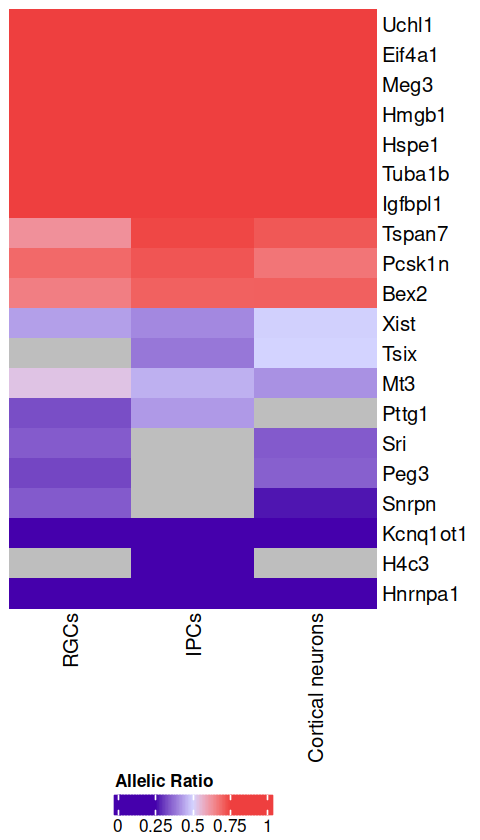

In [25]:
options(repr.plot.width = 4, repr.plot.height = 7)
cont_pal <- pal_gsea()(11)
ht <- ComplexHeatmap::Heatmap(top20genes_ar, cluster_rows = F, cluster_columns = FALSE, 
                        heatmap_legend_param = list(direction = "horizontal", at = seq(0, 1, 0.25)), name = "Allelic Ratio",
                        row_names_side = "right", col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]))
draw(ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

### Figure 5C

Comparing the allelic ratio distribution for genes with RME and the distribution for genes with similar expression levels. 

In [40]:
# Finding a set of genes matched by expression

#selecting genes with RME
organoids_res_rme <- lapply(organoids_res, function(q) q[q$rme == 1,])
rme_comb <- do.call(rbind, organoids_res_rme)

#selecting genes with no edidence of monoallelic expression
organoids_res_notmonal <- lapply(organoids_res, function(q) q[q$mono == 0,])
notmonal_comb <- do.call(rbind, organoids_res_notmonal)

In [41]:
#combining datasets
organoids_comb_sub <- rbind(rme_comb, notmonal_comb)
dim(organoids_comb_sub)

[1] 2863   39

In [42]:
#Finding genes matches by expression to the RME genes
set.seed(10011011)
match.out <- matchit(rme ~ tot_gene_mean, data = organoids_comb_sub,
                     method = "nearest", distance = "glm")
matched_genes <- as.data.frame(match.out[["match.matrix"]])
colnames(matched_genes) <- "gene_id"
matched_genes$gene_name <- organoids_comb_sub$gene[match(matched_genes$gene_id, rownames(organoids_comb_sub))]
matched_genes$celltype <- organoids_comb_sub$celltype[match(matched_genes$gene_id, rownames(organoids_comb_sub))]
matched_genes$gene_orig <- organoids_comb_sub$gene[match(rownames(matched_genes), rownames(organoids_comb_sub))]
head(matched_genes)

,gene_id,gene_name,celltype,gene_orig
,<chr>,<chr>,<chr>,<chr>
Lypd1,Ndc80,Ndc80,IPCs,Lypd1
Snhg11,Svil,Svil,IPCs,Snhg11
Pcsk1n,Npm1,Npm1,Cortical neurons,Pcsk1n
Tspan7,Palm,Palm,Cortical neurons,Tspan7
Ndufb11,Guk11,Guk1,RGCs,Ndufb11
Uba1,Bcan,Bcan,RGCs,Uba1


In [43]:
matched_genes_list <- split(matched_genes, f = matched_genes$celltype)

In [46]:
#Loading raw allelic counts
celltypes <- list("Cortical neurons", "IPCs", "RGCs")
res <- "./data/brain_organoids/Bl6Cast/"

a1_counts <- lapply(celltypes, function(q) read.csv(paste0(res, q, "Bl6_Cast_a1.csv")))
a1_counts <- lapply(a1_counts, function(q) tibble::column_to_rownames(q, var = "X"))

a2_counts <- lapply(celltypes, function(q) read.csv(paste0(res, q, "Bl6_Cast_a2.csv")))
a2_counts <- lapply(a2_counts, function(q) tibble::column_to_rownames(q, var = "X"))


In [54]:
#calculating observed vs expected in stohastic monoallelic genes
plot_data_1 <- list()
for (i in 1:dim(matched_genes_list[[1]])[1]){
    plot_data_1[[i]] <- make_plotdf_simul(a1_counts[[1]], a2_counts[[1]], 
                                          gene = matched_genes_list[[1]]$gene_orig[i], organoids_res[[1]])
}    

plot_data_2 <- list()
for (i in 1:dim(matched_genes_list[[2]])[1]){
    plot_data_2[[i]] <- make_plotdf_simul(a1_counts[[2]], a2_counts[[2]], 
                                          gene = matched_genes_list[[2]]$gene_orig[i], organoids_res[[2]])
} 

plot_data_3 <- list()
for (i in 1:dim(matched_genes_list[[3]])[1]){
    plot_data_3[[i]] <- make_plotdf_simul(a1_counts[[3]], a2_counts[[3]], 
                                          gene = matched_genes_list[[3]]$gene_orig[i], organoids_res[[3]])
}

Warning message in rbeta(n = ssum.ind3, shape1 = shape1[!ind3], shape2 = shape2[!ind3]):
“NAs produced”
Warning message in rbinom(n = ssum.ind3, size = size[!ind3], prob = rbeta(n = ssum.ind3, :
“NAs produced”
Warning message in rbeta(n = ssum.ind3, shape1 = shape1[!ind3], shape2 = shape2[!ind3]):
“NAs produced”
Warning message in rbinom(n = ssum.ind3, size = size[!ind3], prob = rbeta(n = ssum.ind3, :
“NAs produced”
Warning message in rbeta(n = ssum.ind3, shape1 = shape1[!ind3], shape2 = shape2[!ind3]):
“NAs produced”
Warning message in rbinom(n = ssum.ind3, size = size[!ind3], prob = rbeta(n = ssum.ind3, :
“NAs produced”
Warning message in rbeta(n = ssum.ind3, shape1 = shape1[!ind3], shape2 = shape2[!ind3]):
“NAs produced”
Warning message in rbinom(n = ssum.ind3, size = size[!ind3], prob = rbeta(n = ssum.ind3, :
“NAs produced”
Warning message in rbeta(n = ssum.ind3, shape1 = shape1[!ind3], shape2 = shape2[!ind3]):
“NAs produced”
Warning message in rbinom(n = ssum.ind3, size = size[!in

In [55]:
plot_data_1 <- do.call(rbind, plot_data_1)
plot_data_2 <- do.call(rbind, plot_data_2)
plot_data_3 <- do.call(rbind, plot_data_3)

In [56]:
head(plot_data_1)

,a1,a2,tot,AR,a1_post,a2_post,AR_post,a1_common,a2_common,AR_common,Index
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,2,0,2,1.0000000,2,0,1.0000000,1,1,0.5000000,2
3,10,0,10,1.0000000,0,10,0.0000000,5,5,0.5000000,3
4,1,0,1,1.0000000,0,1,0.0000000,1,0,1.0000000,4
5,0,6,6,0.0000000,6,0,1.0000000,3,3,0.5000000,5
6,11,2,13,0.8461538,13,0,1.0000000,10,3,0.7692308,6
7,0,3,3,0.0000000,2,1,0.6666667,3,0,1.0000000,7


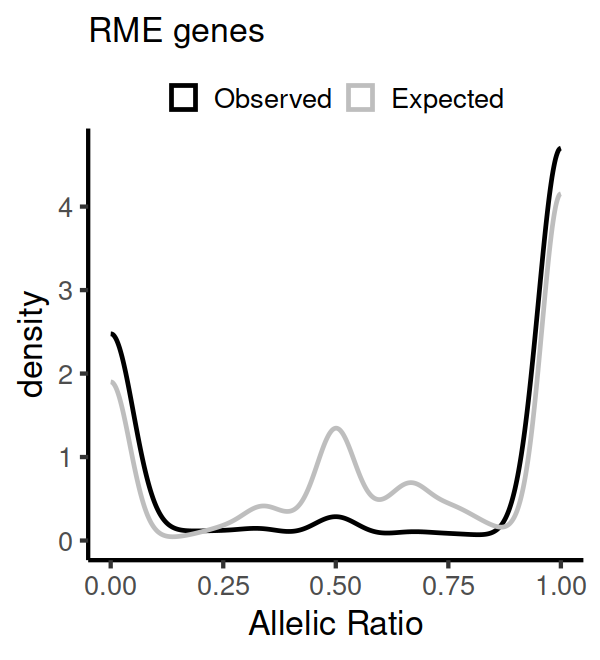

In [59]:
options(repr.plot.width = 5, repr.plot.height = 5.5)
plot_data <- rbind(plot_data_1, plot_data_2, plot_data_3)
exp_dist <- plot_density(plot_data) + labs(subtitle = "RME genes")
exp_dist

Visualising deviation of RME genes from the expected trend. For this plot, all cell types were combined.

In [62]:
organoids_comb <- do.call(rbind, organoids_res)

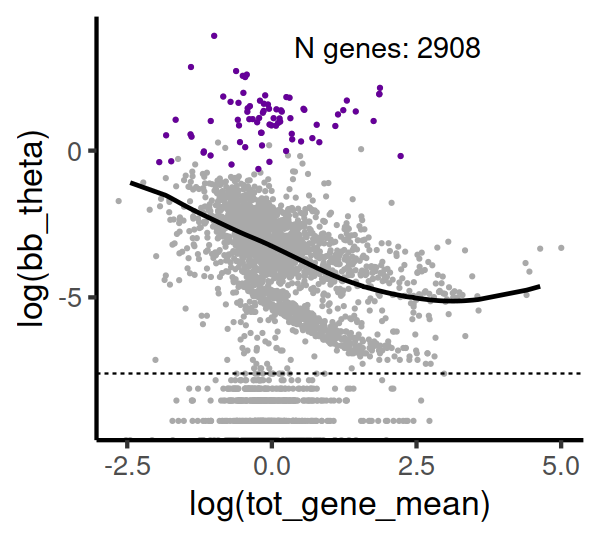

In [69]:
options(repr.plot.width = 5, repr.plot.height = 4.5)
plot_scatter(organoids_comb) +
    geom_line(data = subset(organoids_comb, celltype == "RGCs"), aes(log(tot_gene_mean), log(theta_common)), 
                color = "black", linewidth = 1, group = 1) +
    geom_hline(yintercept = log(5e-04), linetype = "dashed", linewidth = 0.5) +
    geom_point(data = subset(organoids_comb, rme == 1), colour = "#660099", size = 0.7) 

### Supplemetal Figure 4A

Allelic ratio distribution in genes with monoallelic expression, including imprinted and autosomal gene examples.

In [72]:
gene = "Meg3"
plot_data <- mapply(function(p, q) makedf(p, q, gene = gene),
                    a1_counts, a2_counts, SIMPLIFY = F)
plots <- mapply(function(p, q) plot_distr_totGE(p, gene),
                plot_data, celltypes[c(1,3,4)], SIMPLIFY = F)

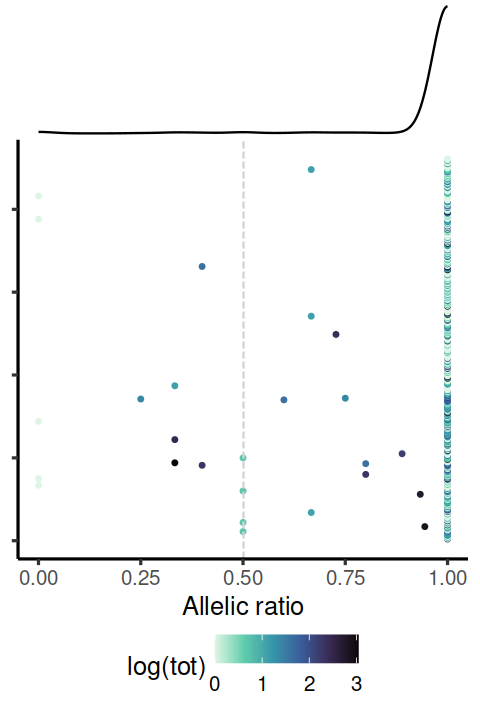

In [74]:
options(repr.plot.width = 4, repr.plot.height = 6)
plots[[3]] 

In [75]:
gene = "Eif4a1"
plot_data <- mapply(function(p, q) makedf(p, q, gene = gene),
                    a1_counts, a2_counts, SIMPLIFY = F)
plots <- mapply(function(p, q) plot_distr_totGE(p, gene),
                plot_data, celltypes[c(1,3,4)], SIMPLIFY = F)

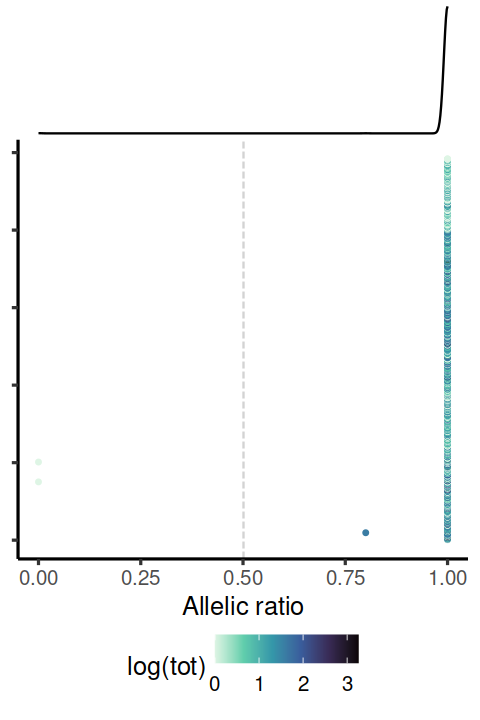

In [80]:
plots[[1]] 

In [81]:
gene = "Hnrnpa1"
plot_data <- mapply(function(p, q) makedf(p, q, gene = gene),
                    a1_counts, a2_counts, SIMPLIFY = F)
plots <- mapply(function(p, q) plot_distr_totGE(p, gene),
                plot_data, celltypes[c(1,3,4)], SIMPLIFY = F)

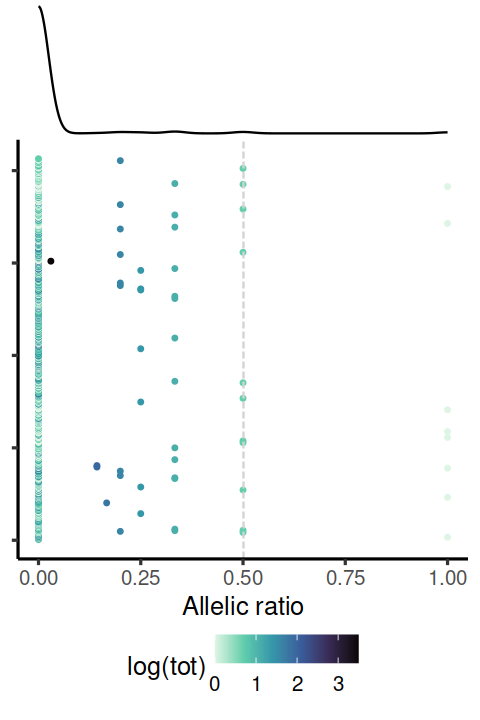

In [85]:
plots[[1]] 

### Figure 5B

Detecting incomplete X chromosome inactivation. Chromosome X genes that had allelic ratio between 0.25 and 0.75 in at least 15% of cells with a minimum of five reads were defined as incompletely inactivated.

In [88]:
organoids_res_mono <- lapply(organoids_res, function(q) q[q$mono == 1,])
mono_comb <- do.call(rbind, organoids_res_mono)
table(!duplicated(mono_comb$gene))


FALSE  TRUE 
   49    72 

In [89]:
#selectinggenes located on the sex chromosomes
genesXY <- read.table("./misc/mm10_genesXY.txt")
mono_comb_XY <-  mono_comb[mono_comb$gene %in% genesXY$V1,]
table(!duplicated(mono_comb_XY$gene))


FALSE  TRUE 
   32    27 

In [90]:
chrX_genes <- mono_comb_XY$gene[!duplicated(mono_comb_XY$gene)]
chrX_genes

[1] "Pcsk1n"  "Tspan7"  "Ndufb11" "Uba1"    "Pgrmc1"  "Aff2"    "Ids"    
 [8] "Nsdhl"   "Maged1"  "Rps4x"   "Tsix"    "Xist"    "Atrx"    "Sh3bgrl"
[15] "Bex2"    "Pak3"    "Dcx"     "Zrsr2"   "Gpm6b"   "Nono"    "Tceal8" 
[22] "Prdx4"   "Tmem47"  "Pdzd11"  "Magt1"   "Mageh1"  "Rab9"

In [159]:
#extracting counts for chrX genes in RGCs
count_data_RGCs <- list()
for (i in 1:length(genes)){
    count_data_RGCs[[i]] <- tryCatch(makedf(a1_counts[[3]], a2_counts[[3]], gene = chrX_genes[i]),
                                                         error = function(e) {NA})
    }

Constracting a dataframe with: 
- the total number of cells;
- the number of cells meeting the counts cut-off;
- the number of cells with mean allelic ratio between 0.25 and 0.75; and
- the number of cells with mean allelic ratio between 0.4 and 0.6.

In [160]:
res_RGCs <- list()
for (i in 1:length(count_data_RGCs)){
        res_RGCs[[i]] <- tryCatch(as.data.frame(cbind("tot_cells" = length(count_data_RGCs[[i]]$AR),
             "cutoff_cells" = length(count_data_RGCs[[i]]$AR[count_data_RGCs[[i]]$tot >= 5]),
            "n_cells_0.75" = length(count_data_RGCs[[i]]$AR[count_data_RGCs[[i]]$AR > 0.25 & 
                                                       count_data_RGCs[[i]]$AR < 0.75 &
                                                      count_data_RGCs[[i]]$tot >= 5]),
            "n_cells_0.6" = length(count_data_RGCs[[i]]$AR[count_data_RGCs[[i]]$AR > 0.4 & 
                                                       count_data_RGCs[[i]]$AR < 0.6 &
                                                      count_data_RGCs[[i]]$tot >= 5])
             )), error = function(e) {NA})

    }

In [161]:
#adding genes names to the row names
idx <- which(is.na(res_RGCs))
res_RGCs <- res_RGCs[!is.na(res_RGCs)]
for (i in 1:length(res_RGCs)){
    rownames(res_RGCs[[i]]) <- chrX_genes[-idx][i]
}

In [162]:
#calculating proportion of the cells with allelic ratio between 0.25 and 0.75 and 
#the porportion of cell with allelic ratio between 0.4 and 0.6 
res_RGCs <- lapply(res_RGCs, function(q) {q$prop0.75 <- round(q$n_cells_0.75/q$cutoff_cells, 4);
                                        q$prop0.6 <- round(q$n_cells_0.6/q$cutoff_cells, 4);
                                return(q)})

In [163]:
res_RGCs <- do.call(rbind, res_RGCs)
head(res_RGCs)

,tot_cells,cutoff_cells,n_cells_0.75,n_cells_0.6,prop0.75,prop0.6
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Pcsk1n,614,72,14,5,0.1944,0.0694
Tspan7,656,80,5,1,0.0625,0.0125
Ndufb11,739,127,18,1,0.1417,0.0079
Uba1,463,9,3,1,0.3333,0.1111
Pgrmc1,282,1,0,0,0.0000,0.0000
Aff2,72,0,0,0,NaN,NaN


In [177]:
#Genes that met definition of incomplete inactivation in RGCs
res_RGCs[res_RGCs$prop0.75 >= 0.14 & res_RGCs$n_cells_0.75 >= 5,]

,tot_cells,cutoff_cells,n_cells_0.75,n_cells_0.6,prop0.75,prop0.6
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Pcsk1n,614,72,14,5,0.1944,0.0694
Ndufb11,739,127,18,1,0.1417,0.0079
Bex2,725,137,24,6,0.1752,0.0438


Repeating analyses for IPCs

In [165]:
count_data_IPCs <- list()
for (i in 1:length(genes)){
    count_data_IPCs[[i]] <- tryCatch(makedf(a1_counts[[2]], a2_counts[[2]], gene = chrX_genes[i]),
                                                         error = function(e) {NA})
    }


In [166]:
res_IPCs <- list()
for (i in 1:length(count_data_IPCs)){
        res_IPCs[[i]] <- tryCatch(as.data.frame(cbind("tot_cells" = length(count_data_IPCs[[i]]$AR),
             "cutoff_cells" = length(count_data_IPCs[[i]]$AR[count_data_IPCs[[i]]$tot >= 5]),
            "n_cells_0.75" = length(count_data_IPCs[[i]]$AR[count_data_IPCs[[i]]$AR > 0.25 & 
                                                       count_data_IPCs[[i]]$AR < 0.75 &
                                                      count_data_IPCs[[i]]$tot >= 5]),
            "n_cells_0.6" = length(count_data_IPCs[[i]]$AR[count_data_IPCs[[i]]$AR > 0.4 & 
                                                       count_data_IPCs[[i]]$AR < 0.6 &
                                                      count_data_IPCs[[i]]$tot >= 5])
             )), error = function(e) {NA})

    }

In [167]:
idx <- which(is.na(res_IPCs))
res_IPCs <- res_IPCs[!is.na(res_IPCs)]
for (i in 1:length(res_IPCs)){
    rownames(res_IPCs[[i]]) <- chrX_genes[-idx][i]
}

In [168]:

res_IPCs <- lapply(res_IPCs, function(q) {q$prop0.75 <- round(q$n_cells_0.75/q$cutoff_cells, 4);
                                        q$prop0.6 <- round(q$n_cells_0.6/q$cutoff_cells, 4);
                                return(q)})

In [169]:
res_IPCs <- do.call(rbind, res_IPCs)
head(res_IPCs)

,tot_cells,cutoff_cells,n_cells_0.75,n_cells_0.6,prop0.75,prop0.6
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Pcsk1n,759,56,8,1,0.1429,0.0179
Tspan7,414,13,0,0,0.0000,0.0000
Ndufb11,839,25,0,0,0.0000,0.0000
Uba1,620,8,2,0,0.2500,0.0000
Pgrmc1,330,2,0,0,0.0000,0.0000
Aff2,158,2,0,0,0.0000,0.0000


In [170]:
#Genes that met definition of incomplete inactivation in IPCs
res_IPCs[res_IPCs$prop0.75 >= 0.15 & res_IPCs$n_cells_0.75 >= 5,]

,tot_cells,cutoff_cells,n_cells_0.75,n_cells_0.6,prop0.75,prop0.6
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Sh3bgrl,743,24,5,0,0.2083,0


Repeating analyses for the cortical neurons

In [171]:
count_data_CNs <- list()
for (i in 1:length(genes)){
    count_data_CNs[[i]] <- tryCatch(makedf(a1_counts[[1]], a2_counts[[1]], gene = chrX_genes[i]),
                                                         error = function(e) {NA})
    }

In [172]:
res_CNs <- list()
for (i in 1:length(count_data_CNs)){
        res_CNs[[i]] <- tryCatch(as.data.frame(cbind("tot_cells" = length(count_data_CNs[[i]]$AR),
             "cutoff_cells" = length(count_data_CNs[[i]]$AR[count_data_CNs[[i]]$tot >= 5]),
            "n_cells_0.75" = length(count_data_CNs[[i]]$AR[count_data_CNs[[i]]$AR > 0.25 & 
                                                       count_data_CNs[[i]]$AR < 0.75 &
                                                      count_data_CNs[[i]]$tot >= 5]),
            "n_cells_0.6" = length(count_data_IPCs[[i]]$AR[count_data_CNs[[i]]$AR > 0.4 & 
                                                       count_data_CNs[[i]]$AR < 0.6 &
                                                      count_data_CNs[[i]]$tot >= 5])
             )), error = function(e) {NA})

    }

In [173]:
idx <- which(is.na(res_CNs))
res_CNs <- res_CNs[!is.na(res_CNs)]
for (i in 1:length(res_CNs)){
    rownames(res_CNs[[i]]) <- chrX_genes[-idx][i]
}

In [174]:
res_CNs <- lapply(res_CNs, function(q) {q$prop0.75 <- round(q$n_cells_0.75/q$cutoff_cells, 4);
                                        q$prop0.6 <- round(q$n_cells_0.6/q$cutoff_cells, 4);
                                return(q)})

In [175]:
res_CNs <- do.call(rbind, res_CNs)
head(res_CNs)

,tot_cells,cutoff_cells,n_cells_0.75,n_cells_0.6,prop0.75,prop0.6
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Pcsk1n,1248,439,24,6,0.0547,0.0137
Tspan7,746,22,1,1,0.0455,0.0455
Ndufb11,899,23,4,1,0.1739,0.0435
Uba1,947,27,9,4,0.3333,0.1481
Pgrmc1,677,9,2,1,0.2222,0.1111
Aff2,574,5,0,0,0.0000,0.0000


In [176]:
#Genes that met definition of incomplete inactivation in cortical neurons
res_CNs[res_CNs$prop0.75 >= 0.15 & res_CNs$n_cells_0.75 >= 5,]

,tot_cells,cutoff_cells,n_cells_0.75,n_cells_0.6,prop0.75,prop0.6
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Uba1,947,27,9,4,0.3333,0.1481


Plotting allelic ratio distribution for the identified gene set 

In [180]:
genes_to_use <- list("Bex2", "Ndufb11", "Uba1", "Sh3bgrl", "Pcsk1n")

Constructing data frames for plotting

In [193]:
plot_data_RGCs <- lapply(genes_to_use[c(1,2,5)], function(q) makedf(a1_counts[[3]], a2_counts[[3]], gene = q))
plot_data_RGCs <- lapply(plot_data_RGCs, function(q) {q$group <- "1"; return(q)})               
dens_RGCs <- mapply(function(p, q) plot_scatter_density(p) + labs(title = q), plot_data_RGCs, genes_to_use[c(1,2,5)], SIMPLIFY = F)


In [194]:
plot_data_IPCs <- lapply(genes_to_use[4], function(q) makedf(a1_counts[[2]], a2_counts[[2]], gene = q))
plot_data_IPCs <- lapply(plot_data_IPCs, function(q) {q$group <- "1"; return(q)})               
dens_IPCs <- mapply(function(p, q) plot_scatter_density(p) + labs(title = q), plot_data_IPCs, genes_to_use[4], SIMPLIFY = F)


In [195]:
plot_data_cortneur <- lapply(genes_to_use[3], function(q) makedf(a1_counts[[1]], a2_counts[[1]], gene = q))
plot_data_cortneur <- lapply(plot_data_cortneur, function(q) {q$group <- "1"; return(q)})               
dens_cortneur <- mapply(function(p, q) plot_scatter_density(p) + labs(title = q), plot_data_cortneur, genes_to_use[3], SIMPLIFY = F)


Picking joint bandwidth of 0.102

Picking joint bandwidth of 0.109

Picking joint bandwidth of 0.105

Picking joint bandwidth of 0.106

Picking joint bandwidth of 0.101



TableGrob (1 x 5) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (1-1,4-4) arrange gtable[layout]
5 5 (1-1,5-5) arrange gtable[layout]

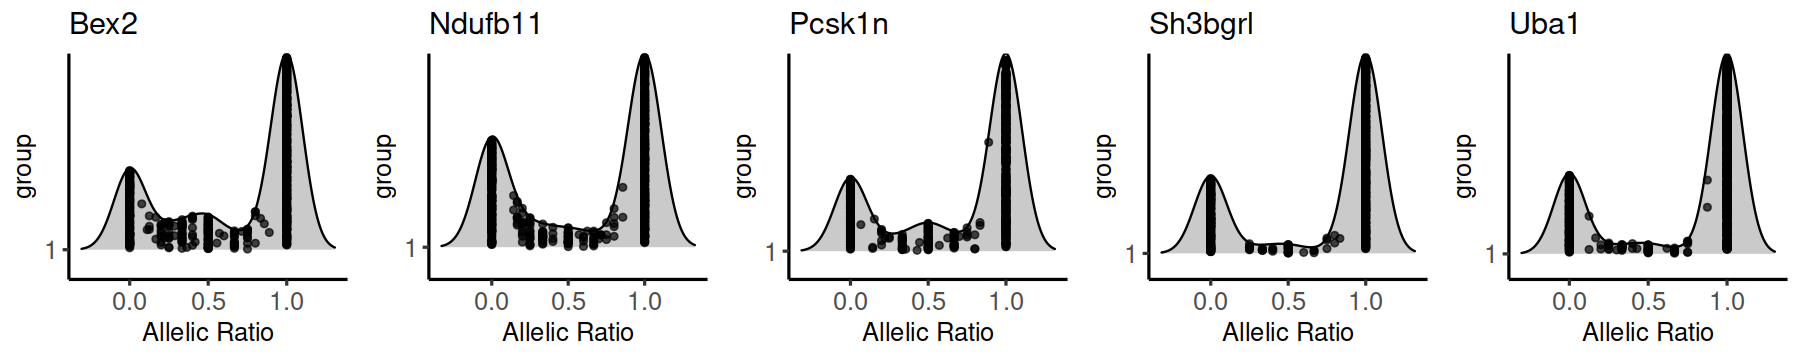

In [196]:
options(repr.plot.width = 15, repr.plot.height = 3)
dens_plots <- c(dens_RGCs, dens_IPCs, dens_cortneur)
p <- do.call(grid.arrange, c(dens_plots, ncol = 5))
p

### Figure 5C and Supplemental Figure 4B

Allelic ratio distribution for the genes with RME

In [198]:
#selecting genes identified as RME
organoids_res_rme <- lapply(organoids_res, function(q) q[q$rme == 1,])
rme_comb <- do.call(rbind, organoids_res_rme)

In [205]:
#excluding X chromosome genes and selecting only autosomal genes
arme_comb <- rme_comb[!(rme_comb$gene %in% genesXY$V1),]
arme_genes <- arme_comb$gene[!duplicated(arme_comb$gene)]
arme_genes <- arme_genes[order(arme_genes)]
arme_genes                         

[1] "Acot1"   "Emp2"    "Gadd45g" "H2bc4"   "Hmgn3"   "Lypd1"   "Mt3"    
 [8] "Nefm"    "Pttg1"   "Snhg11"  "Thrsp"   "Tubb2a"

In [206]:
arme_genes <- as.list(arme_genes)

Constructing a dataframe for plotting

In [207]:
plot_data_RGCs <- lapply(arme_genes[c(1,2,5,11)], function(q) makedf(a1_counts[[3]], a2_counts[[3]], gene = q))
plot_data_RGCs <- lapply(plot_data_RGCs, function(q) {q$group <- "1"; return(q)})               
dens_RGCs <- mapply(function(p, q) plot_scatter_density(p) + labs(title = q), plot_data_RGCs, arme_genes[c(1,2,5,11)], SIMPLIFY = F)


In [209]:
plot_data_IPCs <- lapply(arme_genes[c(3,4,7,9)], function(q) makedf(a1_counts[[2]], a2_counts[[2]], gene = q))
plot_data_IPCs <- lapply(plot_data_IPCs, function(q) {q$group <- "1"; return(q)})               
dens_IPCs <- mapply(function(p, q) plot_scatter_density(p) + labs(title = q), plot_data_IPCs, arme_genes[c(3,4,7,9)], SIMPLIFY = F)


In [210]:
plot_data_cortneur <- lapply(arme_genes[c(6,8,10,12)], function(q) makedf(a1_counts[[1]], a2_counts[[1]], gene = q))
plot_data_cortneur <- lapply(plot_data_cortneur, function(q) {q$group <- "1"; return(q)})               
dens_cortneur <- mapply(function(p, q) plot_scatter_density(p) + labs(title = q), plot_data_cortneur, arme_genes[c(6,8,10,12)], SIMPLIFY = F)


Picking joint bandwidth of 0.145

Picking joint bandwidth of 0.163

Picking joint bandwidth of 0.134

Picking joint bandwidth of 0.144

Picking joint bandwidth of 0.122

Picking joint bandwidth of 0.145

Picking joint bandwidth of 0.12

Picking joint bandwidth of 0.151

Picking joint bandwidth of 0.159

Picking joint bandwidth of 0.15

Picking joint bandwidth of 0.132

Picking joint bandwidth of 0.107



TableGrob (2 x 6) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (1-1,5-5) arrange gtable[layout]
6   6 (1-1,6-6) arrange gtable[layout]
7   7 (2-2,1-1) arrange gtable[layout]
8   8 (2-2,2-2) arrange gtable[layout]
9   9 (2-2,3-3) arrange gtable[layout]
10 10 (2-2,4-4) arrange gtable[layout]
11 11 (2-2,5-5) arrange gtable[layout]
12 12 (2-2,6-6) arrange gtable[layout]

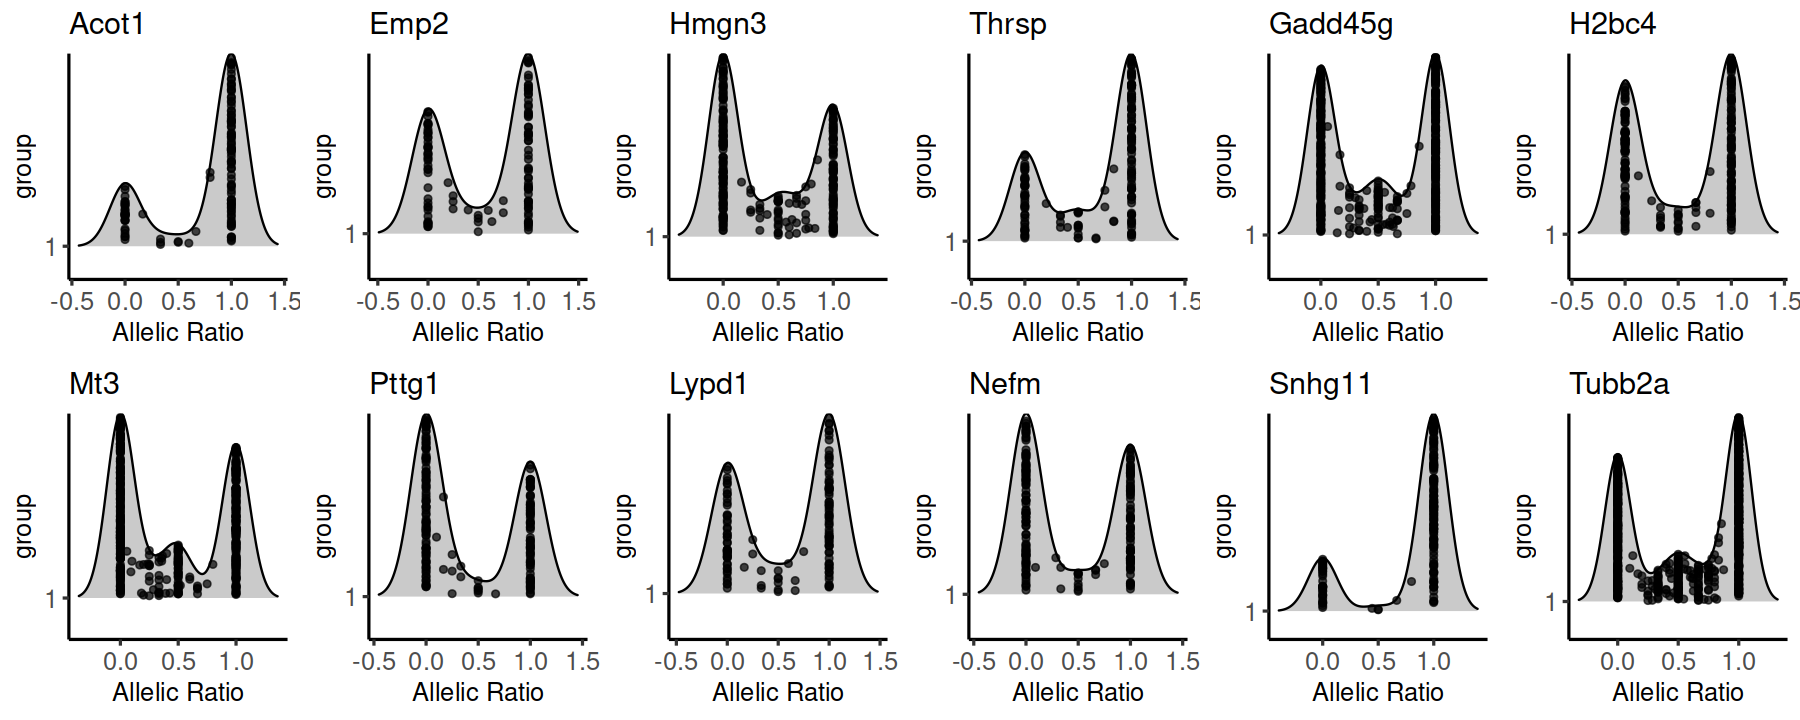

In [212]:
options(repr.plot.width = 15, repr.plot.height = 6)
dens_plots <- c(dens_RGCs, dens_IPCs, dens_cortneur)
p <- do.call(grid.arrange, c(dens_plots, nrow = 2))
p